Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos <br>
Primer Semestre 2024
<br>

<h1><center>Tarea 4: Modelos para imágenes y texto </center></h1>
        Profesor: Marcelo Mendoza<br>
        Fecha de entrega: 09 de junio de 2024

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas.
- El notebook debe tener todas las celdas de código ejecutadas.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.

---

## Librerías

In [1]:
#Cargue las liberías que va a utilizar
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from tensorflow.keras import layers
from keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Sección 1: Clasificación de imágenes (30 puntos)

Para esta primera sección se utilizará el dataset de imágenes **MNIST**. Este conjunto de datos incluye números escritos manualmente, entre 0 y 9.

Cada imágen tiene una dimensión de 28x28 y está en blanco y negro. Es decir, una imagen se ve representada como un arreglo de dimensión (28, 28).

Más información: http://yann.lecun.com/exdb/mnist/

## Parte 1: Carga de datos y procesamiento (5 puntos)

### 1.1 Importe el dataset y analicelo (4 puntos)  

* Indique el número de imágenes que posee el conjunto de datos. ¿Las clases están balanceadas?
* Muestre dos imágenes de cada clase.


In [2]:
#Entregar esta celda
#Cargar dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#Normalización
x_train = x_train / 255
x_test = x_test / 255

RESPUESTA:

In [3]:
num_train_images = x_train.shape[0]
num_test_images = x_test.shape[0]
total_images = num_train_images + num_test_images

print(f'Número de imágenes en el conjunto de entrenamiento: {num_train_images}')
print(f'Número de imágenes en el conjunto de prueba: {num_test_images}')
print(f'Número total de imágenes: {total_images}')

Número de imágenes en el conjunto de entrenamiento: 60000
Número de imágenes en el conjunto de prueba: 10000
Número total de imágenes: 70000


In [4]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution_train = dict(zip(unique, counts))

unique, counts = np.unique(y_test, return_counts=True)
class_distribution_test = dict(zip(unique, counts))

cantidad_clases = {}

for k, v in class_distribution_train.items():
    cantidad_clases[k] = v

for k, v in class_distribution_test.items():
    cantidad_clases[k] += v

suma_total = sum(cantidad_clases.values())

for k, v in cantidad_clases.items():
    print(f'Clase {k}: {v} imágenes')
    print(f'Porcentaje de imágenes: {v / suma_total * 100:.2f}%')

Clase 0: 6903 imágenes
Porcentaje de imágenes: 9.86%
Clase 1: 7877 imágenes
Porcentaje de imágenes: 11.25%
Clase 2: 6990 imágenes
Porcentaje de imágenes: 9.99%
Clase 3: 7141 imágenes
Porcentaje de imágenes: 10.20%
Clase 4: 6824 imágenes
Porcentaje de imágenes: 9.75%
Clase 5: 6313 imágenes
Porcentaje de imágenes: 9.02%
Clase 6: 6876 imágenes
Porcentaje de imágenes: 9.82%
Clase 7: 7293 imágenes
Porcentaje de imágenes: 10.42%
Clase 8: 6825 imágenes
Porcentaje de imágenes: 9.75%
Clase 9: 6958 imágenes
Porcentaje de imágenes: 9.94%


En general se ve que las clases estan bastante balanceadas, con algunas diferencias minimas con las clases 1, 3 y 8 que tienen más imagenes

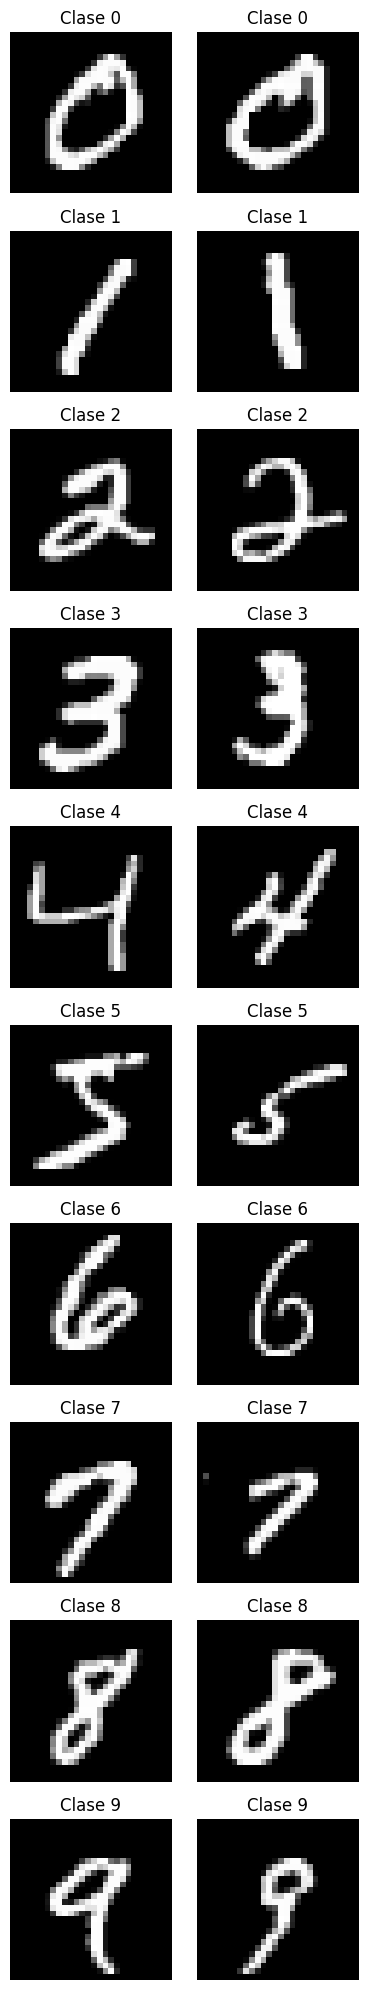

In [5]:
fig, axes = plt.subplots(10, 2, figsize=(4, 20))
for i in range(10):
    class_indices = np.where(y_train == i)[0]
    axes[i, 0].imshow(x_train[class_indices[0]], cmap='gray')
    axes[i, 0].set_title(f'Clase {i}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(x_train[class_indices[1]], cmap='gray')
    axes[i, 1].set_title(f'Clase {i}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

### 1.2 Creación de validación (1 punto)

Utilizando el conjunto train, construya un conjunto de validación (10%).


RESPUESTA:

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

## Parte 2: Crear clasificadores utilizando Convolutional Neural Network (CNN) (25 puntos)

### 2.1 Crear clasificador CNN (10 puntos)

* Entrene un clasificador multiclase para discriminar entre los diez dígitos del dataset. Considere 3 épocas y batch_size=64.

* Grafique las curvas de accuracy para los conjuntos train y validation.
Comente.
* Grafique las funciones de pérdida para los conjuntos train y validation. Comente.

* Utilizando el conjunto de test, calcule las métricas F1-score, precision y recall para cada clase. Comente.

**Observaciones**

* Considere que el número de parámetros de la red puede hacer más lento el proceso de entrenamiento.

* Si utiliza CPU podría demorar entre 4 y 7 minutos por época. En este caso, no tiene límite de tiempo de uso.

* Si utiliza GPU puede acelerar el proceso de entrenamiento significativamente (menos de 1 minuto en total). Google Colab entrega este tipo de recursos de manera gratuita. Para activar la GPU debe ir a la sección **Entorno de ejecución** --> **Cambiar tipo de entorno de ejecución** y seleccionar la opción **T4 GPU**. Considere que el tiempo de uso es limitado.


RESPUESTA:

In [7]:
# Obtenido desde la clase de CNN ya que fue usado para basicamente el mismo proposito
model = Sequential()

# 32 filtros de 5x5, tamaño de entrada igual al de salida
model.add(Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2))) # Se reduce a la mitad la dimension de la imagen
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten()) # Se transforma a una dimension
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

c:\Users\franc\OneDrive - Universidad Católica de Chile\UC\7° Semestre\Mineria de datos\IIC2433\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Obtenido desde la clase de CNN
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Se cumple 3 epocas, de tamaño 64 y se usa el conjunto de validacion
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=3,
    validation_data=(x_val, y_val),
    verbose=2
)

Epoch 1/3
844/844 - 24s - 28ms/step - accuracy: 0.9396 - loss: 0.1921 - val_accuracy: 0.9855 - val_loss: 0.0485
Epoch 2/3
844/844 - 23s - 27ms/step - accuracy: 0.9802 - loss: 0.0670 - val_accuracy: 0.9872 - val_loss: 0.0478
Epoch 3/3
844/844 - 23s - 27ms/step - accuracy: 0.9847 - loss: 0.0494 - val_accuracy: 0.9898 - val_loss: 0.0344


In [10]:
loss, accuracy = model.evaluate(x_train, y_train)
print("Final training loss: {:.8f}".format(loss))
print("Final training accuracy: {:.4%}".format(accuracy))

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9924 - loss: 0.0232
Final training loss: 0.02330105
Final training accuracy: 99.2185%


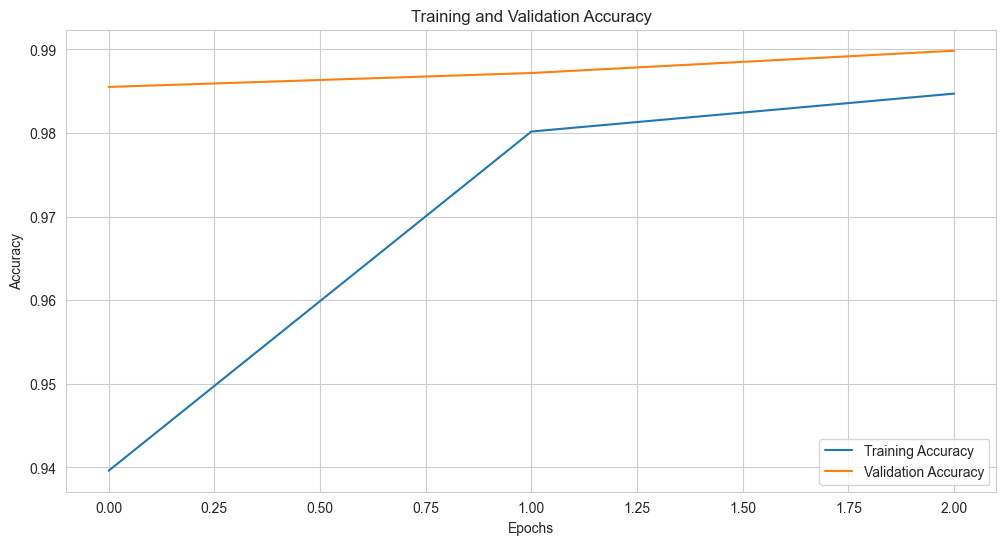

In [11]:
# Obtenido desde la clase de CNN modificado
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Se puede ver que el modelo tiene un buen desempeño en general, con un accuracy final cercano a 0.99 en ambos conjuntos. Esto signidica que esta logrando clasificar correctamente la gran mayoria de las imagenes. Además, como las lineas de training y validation estan muy cercanas, se puede ver que no hay overfitting en el modelo.

Es importante considerar que se estan utilizando solo 3 epocas, por lo que el modelo podria mejorar si se aumentaran o quizas llegaria a overfitting.

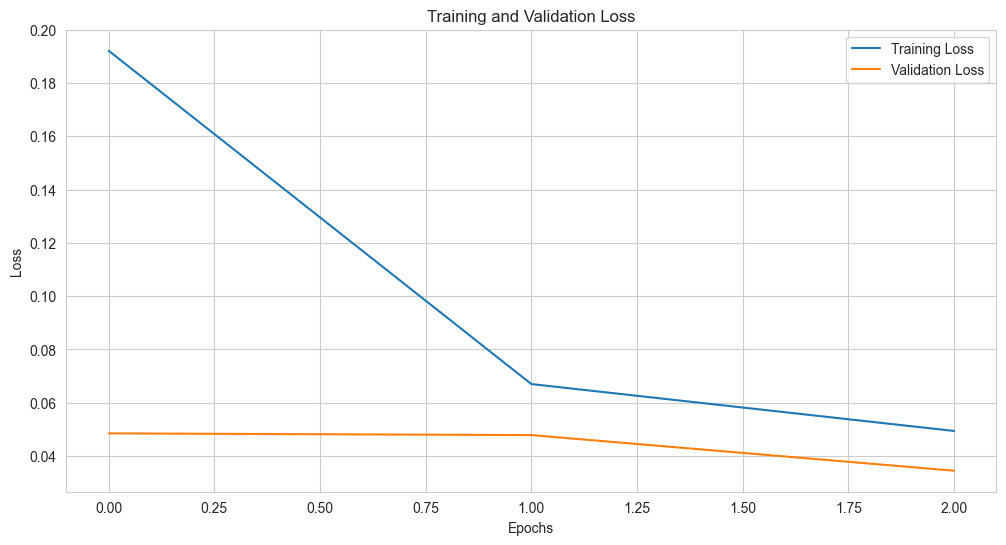

In [12]:
# Obtenido desde la clase de CNN modificado
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Se puede ver que el error de entrenamiento y de validacion disminuyen, lo que indica que el modelo esta aprendiendo correctamente, logrando cada vez clasificar de mejor manera las imagenes.

In [13]:
y_pred = model.predict(x_test).argmax(axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



En general se ve un muy buen desempeño en todas las clases, aunque hay algunas que tiene una menor precisión y recall como el 9 y 4 respectivamente (Esto fue en otra iteracion), lo que provoca que el f1-score sea menor en estas clases. Esto puede deberse a que los números 9 y 4 son muy parecidos a otros números, dependiendo de la forma en la que se escriban.

En general viendo los datos reflejados en esta ultima iteracion, se puede ver que todos tiene un desepempeño muy bueno, estando entre 0.99 y 1 en todas las metricas.

### 2.2 Descripción Variational Autoencoder (VAE) (3 puntos)

Explique la función que cumple el **Encoder** y **Decoder** en la arquitectura VAE.

RESPUESTA:

Encoder: El encoder en VAE tiene la funcion de codificar la imagen de entrada transformandola a un espacio de menor dimension, espacio latente. La idea de este espacio es que las imagenes similares se encuentren más cercanas entre si, manteniendo las caracteristicas más importantes de la imagen original.

Decoder: El decoder, por otro lado, tiene la funcion de reconstruir la imagen original a partir de las variables latentes, esto podria permitir generar nuevas imagenes a partir de la codificacion de una imagen original con las caracteristicas escenciales de esta.

Lo entendido en clases y buscado un poco en internet:

https://en.wikipedia.org/wiki/Variational_autoencoder

https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73


### 2.3 Creación datos sintéticos con VAE (8 puntos)

Utilizando la arquitectura Variational Autoencoder cree 20 ejemplos sintéticos. Muestre las imágenes generadas y comente su calidad.

Utilice 10 épocas y un batch_size igual a 64.

**Observación**

Si utiliza CPU podría demorar entre 1 y 3 minutos por época. En caso de usar GPU, toma menos de 1 minuto en total.

RESPUESTA:

In [15]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [16]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 16)  │      4,624 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 784)       │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │     12,560 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,572 (68.64 KB)

 Trainable params: 17,572 (68.64 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 16, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 16))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,065 (101.82 KB)

 Trainable params: 26,065 (101.82 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [19]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(mnist_digits, epochs=10, batch_size=64)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - kl_loss: 1.1624 - loss: 248.7590 - reconstruction_loss: 247.5967
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - kl_loss: 5.3241 - loss: 174.8061 - reconstruction_loss: 169.4820
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - kl_loss: 5.5769 - loss: 167.7256 - reconstruction_loss: 162.1486
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - kl_loss: 5.8585 - loss: 163.2534 - reconstruction_loss: 157.3949
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - kl_loss: 5.9903 - loss: 160.8907 - reconstruction_loss: 154.9004
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - kl_loss: 6.0267 - loss: 159.3284 - reconstruction_loss: 153.3017
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - kl_loss: 6.0565 - loss: 158.3427 - reconstruction_loss: 152.2862
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - kl_loss: 6.0901 - loss: 157.1630 - reconstruction_loss: 151.0729
Epoch 9/10
1000/

In [20]:
digit_size = 28
scale = 1.0

def generate_image(scale, digit_size):
    x_ = random.uniform(-scale, scale) # sampling de Uniforme[-1,+1]
    y_ = random.uniform(-scale, scale) # sampling de Uniforme[-1,+1]
    z_sample = np.array([[x_, y_]])
    x_decoded = vae.decoder.predict(z_sample) # pasamos por el decoder
    digit = x_decoded[0].reshape(digit_size, digit_size) # le hacemos un reshape al formato de la imagen (28x28)
    return digit

def plot_image(digit):
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(digit, cmap="Greys_r")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


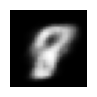

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


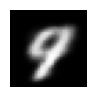

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


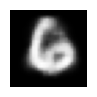

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


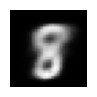

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


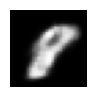

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


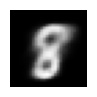

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


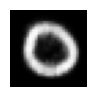

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


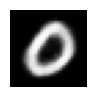

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


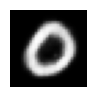

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


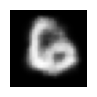

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


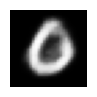

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


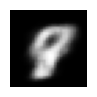

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


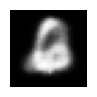

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


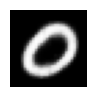

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


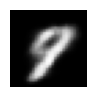

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


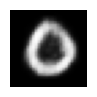

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


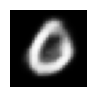

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


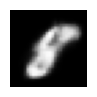

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


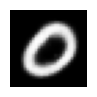

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


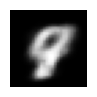

In [21]:
generated_images = []
for i in range(20):
    digit = generate_image(scale, digit_size)
    generated_images.append(digit)
    plot_image(digit)

A simple vista se puede ver que las imagenes generadas son de peor calidad que la originales pero se visualizan distintos numeros por lo que se puede decir que el modelo esta generando imagenes sinteticas de buena manera, logrando obtener las principales caracteristicas de los numeros originales. Importante destacar que le podria faltar obtener mas datos de las imagenes por la falta de calidad.

### 2.4 Evaluar datos sintéticos con clasificador (4 puntos)

Considerando los 20 ejemplos creados en 2.3, aplique el clasificador entrenado en 2.1 para identificar las clases. Comente los resultados.

Si existiera un desbalance en las clases que influye negativamente en las métricas de evaluación, ¿se podrían utilizar estos ejemplos para hacer aumento de datos? Justifique su respuesta en función de los resultados obtenidos al aplicar el clasificador.

RESPUESTA:

In [22]:
print(x_test.shape)

(10000, 28, 28)


In [23]:
generated_images = np.array(generated_images)
predicciones = model.predict(generated_images)
clases = np.argmax(predicciones, axis=1)

print(clases)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[8 9 6 8 8 8 0 0 0 6 0 8 6 0 9 0 0 8 0 9]


En general, considero que el modelo logra clasificar correctamente la gran mayoria de las imagenes (comprando como lo habria hecho yo), aunque hay imagenes que es dificil decir porque son muy parecidas a otros numeros, porque la calidad es baja o porque no se logra ver un numero especifico claramente. 

Tambien es importante mencionar que en la mayoria de las iteraciones de ejecucion si habia un desbalance segun la prediccion, lo que podria ser un problema si se quieren considerar las imagenes generadoas como datos para aumentar. Podria llegar a generar un desbalance en el total de las clases y un posible overfitting en el modelo.

En este ultimo caso se puede ver reflejado en el 8 y 0.

# Sección 2: Clasificación de texto (30 puntos)

El conjunto de datos corresponde a diferentes posts realizados en la plataforma X (aka Twitter) y la respectiva clasificación de la emoción asociada a ese post. Las emociones pueden ser: `sadness/tristeza` (0), `joy/alegria` (1), `love/amor` (2), `anger/enojo` (3), `fear/miedo` (4) y `surprise/sorpresa` (5). La tarea que tendran que realizar es codificar los textos de una manera valida, para luego, poder entrenar un modelo de MLP (y posteriormente, un modelo SVM) para clasificar los textos en las emociones correspondientes, evaluar los rendimientos de los modelos y dar hipotesis sobre por qué creen que un modelo es mejor que otro.

El dataset incluye dos columnas:

* Text: Mensaje de X.
* label: Etiqueta con el sentimiento asignado.

Más información en: `https://www.kaggle.com/datasets/nelgiriyewithana/emotions`

## Parte 1: Carga de Datos (4 Puntos)

### 1.1 Importe el dataset y analicelo (4 puntos)

* Indique el número de elementos por clase.

* Construya un nuevo dataset asegurando que cada clase tenga el mismo tamaño que la clase minoritaria. Para ello utilice un muestreo aleatorio simple sobre las clases que poseen mayor cantidad de ejemplos. ¿Qué ventajas y desventajas tiene este enfoque?

**Observación:**

Debe seguir trabajando con el dataset balanceado.

RESPUESTA:

In [24]:
text = pd.read_csv('text.csv')
text = text.drop(columns=['Unnamed: 0'])
text.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [25]:
text.shape

(416809, 2)

In [26]:
text.isna().sum()

text     0
label    0
dtype: int64

In [27]:
uniques, counts = np.unique(text['label'], return_counts=True)
class_distribution = dict(zip(uniques, counts))

cantidad_clases = {}

for k, v in class_distribution.items():
    cantidad_clases[k] = v

suma_total = sum(cantidad_clases.values())

for k, v in cantidad_clases.items():
    print(f'Clase {k}: {v} textos')
    print(f'Porcentaje de textos: {v / suma_total * 100:.2f}%')

Clase 0: 121187 textos
Porcentaje de textos: 29.07%
Clase 1: 141067 textos
Porcentaje de textos: 33.84%
Clase 2: 34554 textos
Porcentaje de textos: 8.29%
Clase 3: 57317 textos
Porcentaje de textos: 13.75%
Clase 4: 47712 textos
Porcentaje de textos: 11.45%
Clase 5: 14972 textos
Porcentaje de textos: 3.59%


In [28]:
min_class = min(class_distribution.values())
min_class

14972

In [29]:
balanced_text = pd.DataFrame()

for label in class_distribution.keys():
    class_subset = text[text['label'] == label]
    balanced_class_subset = class_subset.sample(n=min_class, random_state=42)
    balanced_text = pd.concat([balanced_text, balanced_class_subset], axis=0)

balanced_text['label'].value_counts()

label
0    14972
1    14972
2    14972
3    14972
4    14972
5    14972
Name: count, dtype: int64

En cuanto a ventajas de este enfoque, se puede ver que se logra balancear el dataset, lo cual puede ser beneficioso para el modelo ya que no se ocurren sesgos por una clase con mayor cantidad y se tiene una mayor generalización.

Por otro lado, una desventaja de este enfoque es que, por ejemplo para este caso, se pierde bastante informacion de las clases con mayor cantidad de datos, ya que se eliminan datos para que todas las clases esten balanceadas. Por esto mismo, se puede llegar a un sobreajuste del modelo y en casos especificos puede que la cantidad sea relevante para mostrar la distribucion de los datos.

## Parte 2: Preprocesamiento (6 Puntos)
Remoción de stopwords, codificación mediante count vectorizer y TF-IDF y generación de conjuntos train y test.

Es importante notar que algunas características del texto, como la longitud de sentencias y frecuencia de palabras, dificultan el proceso de entrenamiento de un modelo de clasificación. Por lo mismo, es necesario realizar un preprocesamiento que permita codificar el texto para entrenar modelos. Para esto, se busca que utilicen diferentes tipos de codificación como `TF-IDF` y `Bag-of-Words(BOW)`. Ambos métodos, ya implementados en sklearn, se encargan de construir una representación vectorial para cada sentencia dentro de un corpus (columna con mensajes).

Posteriormente, para cada una de estas codificaciones, deberá entrenar modelos basados en MLP y SVM para clasificar los textos en las emociones correspondientes y evaluar sus rendimientos.

**Observaciones**

* A continuación, se dejan los enlaces de sklearn para trabajar con los métodos TF-IDF y BOW:
1. TF-IDF:  https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
2. BOW: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

* Para ambas codificaciones, se recomienda utilizar un máximo de 5,000 features (para reducir tiempo de entrenamiento) y remover las stopwords del idioma correspondiente al utilizado en el dataset. `Hint: esto se puede realizar mediante los parametros de las funciones presentadas anteriormente`.

### 2.1 Bag of Words (BOW) (2 puntos)

Utilizando Bag-of-Words, obtenga las representaciones vectoriales de los mensajes de la columna `text`.

RESPUESTA:

In [30]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_bow = count_vectorizer.fit_transform(balanced_text['text'])

### 2.2 TF-IDF (2 puntos)

Utilizando TF-IDF, obtenga las representaciones vectoriales de los mensajes de la columna `text`.

RESPUESTA:

In [31]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(balanced_text['text'])

### 2.3 División de datos para cada encoding (2 puntos)

Divida los datos de cada una de vectorizaciones en `train` y `test`, con un tamaño de `85%` y `15%`, respectivamente. Para esto, debera utilizar la funcion `train_test_split` de `sklearn` con un `random_state=42` (recuerde mantener una proporcion balanceada de las clases).

**Observación**

Para mantener el balance de clases al aplicar `train_test_split` puede utilizar el parámetro `stratify`.

RESPUESTA:

In [32]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, balanced_text['label'], test_size=0.15, random_state=42, stratify=balanced_text['label'])

In [33]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, balanced_text['label'], test_size=0.15, random_state=42, stratify=balanced_text['label'])

## Parte 3: Entrenamiento clasificador MLP (8 puntos)

En esta parte, se busca que usted entrene un modelo de MLP para clasificar los textos en las emociones correspondientes.

**Observación**

Se recomienda trabajar con **MLPClassifier**.

Más información en https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

### 3.1 MLP + BOW (3 puntos)

* Entrene un clasificador MLP utilizando la representación de texto obtenida con Bag-of-Words. Considere 3 capas ocultas de 30 a 50 neuronas cada una, con activación `relu` y 50 iteraciones.

* Utilizando el conjunto de test, calcule las métricas F1-score, precision y recall para cada clase. Comente.

* Grafique la matríz de confusión. Comente.

**Observación**

El proceso de entrenamiento puede tardar entre 1 y 3 minutos, dependiendo del número de neuronas definidas.

RESPUESTA:

In [34]:
mlp_bow = MLPClassifier(hidden_layer_sizes=(30, 30, 30), activation='relu', max_iter=50)
mlp_bow.fit(X_train_bow, y_train_bow)

c:\Users\franc\OneDrive - Universidad Católica de Chile\UC\7° Semestre\Mineria de datos\IIC2433\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(30, 30, 30), max_iter=50)

In [35]:
y_pred_bow = mlp_bow.predict(X_test_bow)
print(classification_report(y_test_bow, y_pred_bow))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2245
           1       0.88      0.81      0.85      2246
           2       0.88      0.92      0.90      2246
           3       0.89      0.88      0.89      2246
           4       0.82      0.82      0.82      2246
           5       0.87      0.87      0.87      2246

    accuracy                           0.87     13475
   macro avg       0.87      0.87      0.87     13475
weighted avg       0.87      0.87      0.87     13475



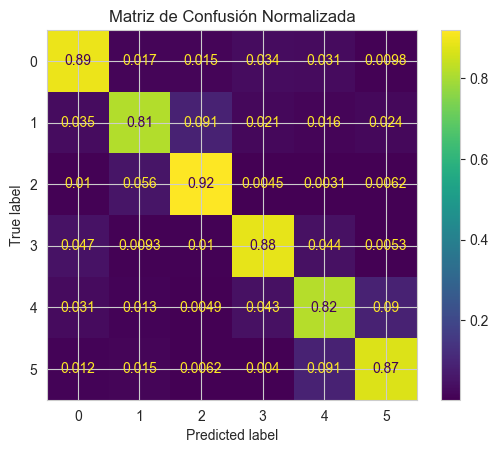

In [36]:
conf_matrix_bow = confusion_matrix(y_test_bow, y_pred_bow, normalize='true')

# https://www.w3schools.com/python/python_ml_confusion_matrix.asp
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bow, display_labels=mlp_bow.classes_)
disp.plot()
plt.title("Matriz de Confusión Normalizada")
plt.show()

### 3.2 MLP + TF-IDF (3 puntos)

* Entrene un clasificador MLP utilizando la representación de texto obtenida con TF-IDF. Considere 3 capas ocultas de 30-50 neuronas cada una, con activación `relu` y 50 iteraciones.

* Utilizando el conjunto de test, calcule las métricas F1-score, precision y recall para cada clase. Comente.

* Grafique la matríz de confusión. Comente.

RESPUESTA:

In [37]:
mlp_tfidf = MLPClassifier(hidden_layer_sizes=(30, 30, 30), activation='relu', max_iter=50)
mlp_tfidf.fit(X_train_tfidf, y_train_tfidf)

c:\Users\franc\OneDrive - Universidad Católica de Chile\UC\7° Semestre\Mineria de datos\IIC2433\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(30, 30, 30), max_iter=50)

In [38]:
y_pred_tfidf = mlp_tfidf.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2245
           1       0.85      0.82      0.83      2246
           2       0.88      0.89      0.89      2246
           3       0.89      0.88      0.88      2246
           4       0.82      0.82      0.82      2246
           5       0.87      0.90      0.88      2246

    accuracy                           0.86     13475
   macro avg       0.86      0.86      0.86     13475
weighted avg       0.86      0.86      0.86     13475



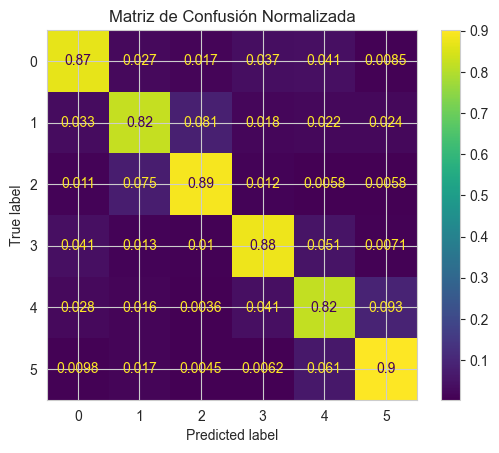

In [39]:
conf_matrix_tfidf = confusion_matrix(y_test_tfidf, y_pred_tfidf, normalize='true')

# https://www.w3schools.com/python/python_ml_confusion_matrix.asp
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tfidf, display_labels=mlp_tfidf.classes_)
disp.plot()
plt.title("Matriz de Confusión Normalizada")
plt.show()

### 3.3 Analisis de resultados - Comparación de encoders (2 puntos)

En este caso, si un modelo con cierto encoding funciono mejor que otro, ¿Por qué creen que fue asi? ¿Que ventajas/desventajas tiene cada uno de los encodings?

RESPUESTA:

En cuanto a la diagonal de las matrices, se puede ver que se comportan más o menos igual, viendo un pequeño mejor desempeño por parte de BOW y lo mismo para la tabla de metricas, teniendo en general mejores valores tanto en la preciosion, recall y f1-score.

Esto puede deberse a que las oraciones son muy cortas por lo que se pudo ver en el head(), entonces BOW por lo investigado suele tener un muy buen rendimiento en este tipo de oraciones y como TF-IDF considera la importancia de las palabras y filtra por algunas. Entonces, como la oracion es tan corta, es posible que BOW haya logrado considerar de mejor manera las palabras más importantes o que mejor definen el sentimiento de la oracion y quizas TF-IDF haya filtrado algunas palabras que podrian ser importantes para la clasificacion.

En cuanto a las ventajas y desventajas:

BOW:

Ventajas:
- Representa cada palabra en un vector considerando la frecuencia de esta
- Util para oracaiones cortas
  
Desventajas:
- No considera la importancia de las palabras

TF-IDF:

Ventajas:
- Considera la importancia de las palabras
- No considera palabras que no aportan información
- Considera la frecuencia de las palabras
  
Desventajas:
- Para este caso, al ser oraciones cortas, podria considerarse como desventaja el hecho de no considerar algunas palabras
- No considera el orden de las palabras

https://www.linkedin.com/pulse/bow-vs-tf-idf-nlp-text-vectorization-hassan-badawy-msc

https://dataknowsall.com/blog/bowtfidf.html

https://medium.com/escueladeinteligenciaartificial/extracci%C3%B3n-de-features-con-bag-of-words-bow-y-tf-idf-para-nlp-f89d678abc0e


## Parte 4: Entrenamiento clasificador SVM (9 puntos)

### 4.1 Entrenamiento modelo SVM (7 puntos)

* **Considerando la vectorizacion que le haya dado mejores resultados en la Parte 3**, entrene un modelo SVM para clasificar los textos en las emociones correspondientes. Para esto, considere los kernels `linear`, `poly` y `rbf`.

* Utilizando el conjunto de test, calcule las métricas F1-score, precision y recall para cada clase. Compare los resultados obtenidos al trabajar con los 3 kernels.

**Observación**

El proceso de entrenamiento al trabajar con los kernels `poly` y `rbf` puede tardar entre 5 y 10 minutos.

RESPUESTA:

In [40]:
kernels = ['linear', 'poly', 'rbf']

for ker in kernels:
  svc = SVC(kernel=ker)
  svc.fit(X_train_bow, y_train_bow)
  y_pred = svc.predict(X_test_bow)
  print(f"Kernel {ker} Accuracy: {accuracy_score(y_test_bow, y_pred)}")
  print(classification_report(y_test_bow, y_pred))
  print("\n")

Kernel linear Accuracy: 0.9002597402597402
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      2245
           1       0.92      0.85      0.88      2246
           2       0.89      0.96      0.93      2246
           3       0.92      0.89      0.91      2246
           4       0.88      0.84      0.86      2246
           5       0.87      0.96      0.92      2246

    accuracy                           0.90     13475
   macro avg       0.90      0.90      0.90     13475
weighted avg       0.90      0.90      0.90     13475



Kernel poly Accuracy: 0.8785899814471243
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2245
           1       0.87      0.84      0.85      2246
           2       0.88      0.94      0.91      2246
           3       0.93      0.85      0.88      2246
           4       0.87      0.82      0.85      2246
           5       0.86      0.95      0.91   

### 4.2 Analisis de resultados - Comparación de kernels (2 puntos).

¿Cómo funcionaron los kernels? ¿Por qué cree que fue asi?

RESPUESTA:

Se puede ver que el que peor rendimiento tuvo fue el kernel polinomial, lo que puede deberse a que el modelo no fue capaz de encontrar una buena separacion de los datos, para grado 2 pues por temas de tiempo de ejecucion no probe con otros grados. Tanto el modelo lineal como el RBF tuvieron un buen desempeño en comparacion con e polinomial, siendo el RBF el que destaca por tener mejores metricas en algunas clases, tanto en precision como en recall. Esto puede ser ya que RBF es un kernel que se adapta mejor a los datos de manera automatica y no es tan restrictivo como el lineal, pues este logra clasificar de mejor manera datos que no son linealmente separables debido a sus cambios de dimensionalidad para los calculos.

## Parte 5: Comparar resultados de MLP y SVM (3 puntos).

¿Qué modelo entregó mejores resultados? ¿Por qué cree que fue asi?

RESPUESTA:

El SVM de kernel RBF y lineal tuvieron bastantes mejores resultados que ambos MLP. Los resultados del kernel polinomial son más cercanos a los que tuvieron los MLP. Esto puede deberse a que los MLPClassifier no lograron obtener las caracteristicas necesarias para realizar la separacion de los datos de mejor manera y si el kernel RBF por ejemplo. El rendimento de los MLP quizas se puede mejorar si se aumentan las capas ocultas o neuronas u otros parametros. 

RBF, por como se menciono anteriormente, logra manejar espacios de mayor dimensionalidad lo que puede ser beneficioso para este tipo de datos, en los que las divisiones no son tan claras linealmente.